# EEG Emotion Prediction using ELECTROENCEPHALOGRAPHY(EEG)

# 1.Libraries

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

2023-07-05 12:38:02.781590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2.Dataset

In [2]:
data=pd.read_csv('emotions.csv')
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


# 3. Data Preprocessing

In [3]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

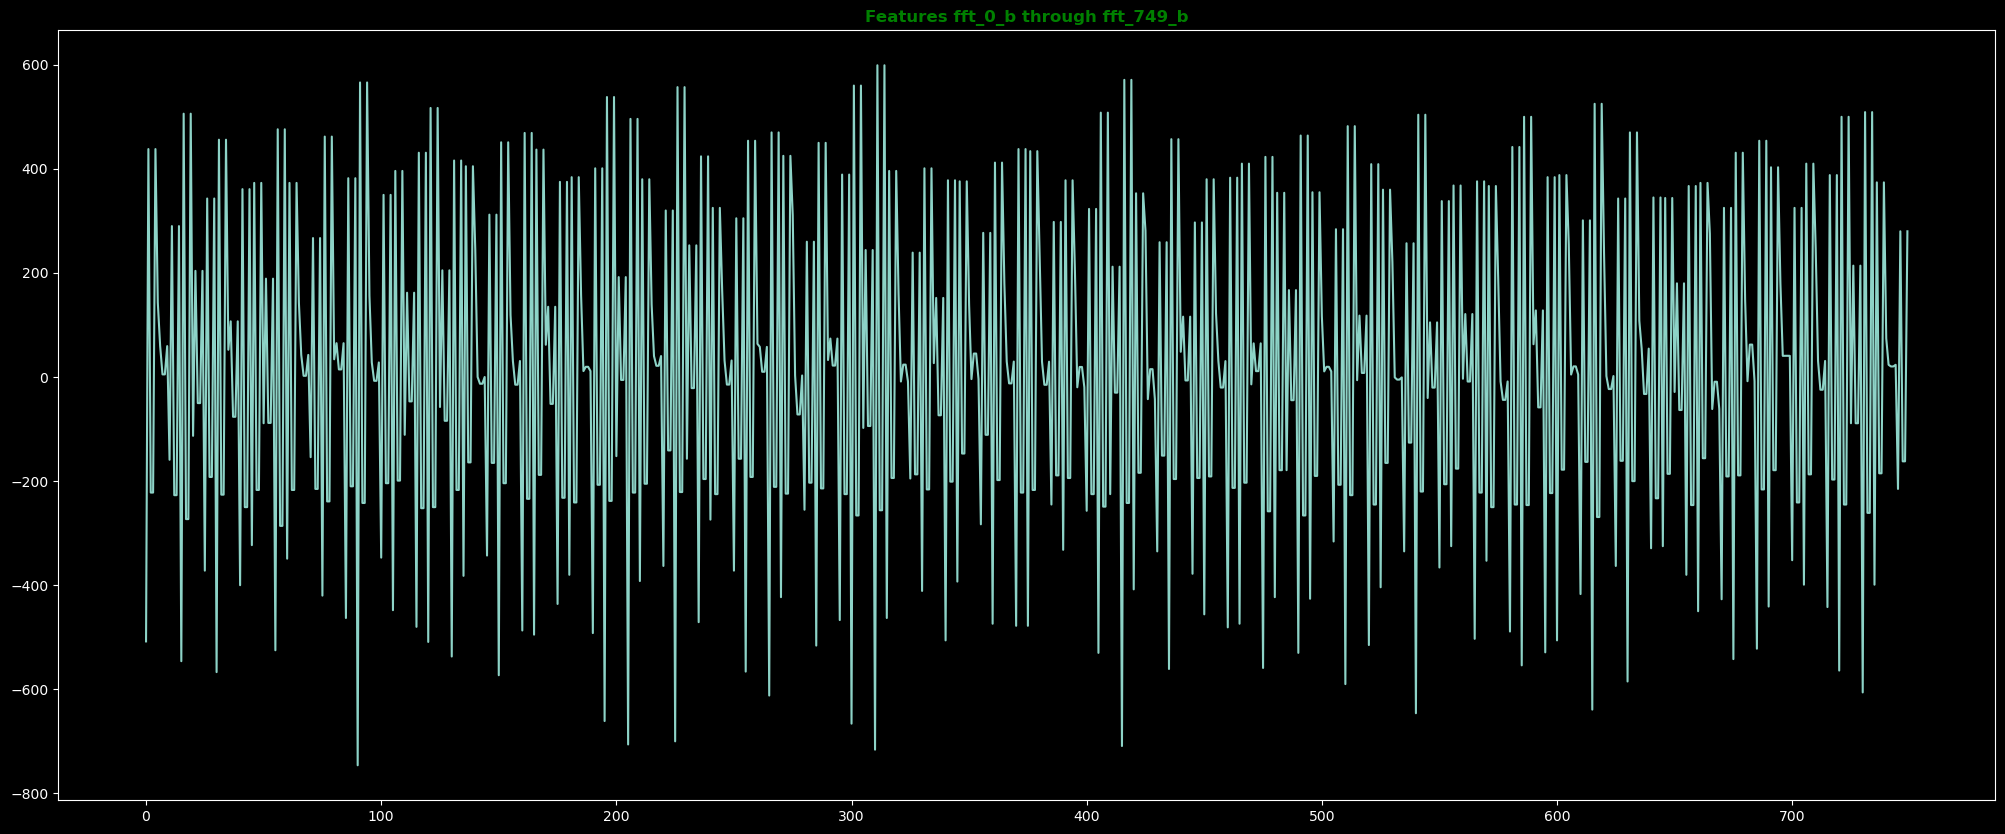

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(25,10))
plt.plot(range(len(sample)),sample)
plt.title("Features fft_0_b through fft_749_b",weight='bold',color='green')
plt.show()


In [5]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


# 4. Encoding 3 distinct labels
The 3 labels are : "NEGATIVE", "NEUTRAL" and "POSITIVE".

In [6]:
data.columns.unique()

Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)

In [7]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['label']=le.fit_transform(data['label'])

* The output of the fit_transform method is a NumPy array that contains the encoded labels. The encoded labels are integers that represent the categories in the original labels. For example, if the original labels were "happy", "sad", "angry", and "fearful", the encoded labels might be 0, 1, 2, and 3, respectively.

# 5. Feature Defining: 


In [8]:
y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

# 6. network architecture : 

In [9]:
from keras.layers import Flatten
from keras.layers import Dense
inputs = tf.keras.Input(shape=(X_train.shape[1],1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)
model.summary()

2023-07-05 12:40:45.958474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548, 1)]         0         
                                                                 
 gru (GRU)                   (None, 2548, 512)         789504    
                                                                 
 flatten (Flatten)           (None, 1304576)           0         
                                                                 
 dense (Dense)               (None, 3)                 3913731   
                                                                 
Total params: 4,703,235
Trainable params: 4,703,235
Non-trainable params: 0
_________________________________________________________________


# 7. Training Model

In [12]:
def train_model(model, x_train, y_train, x_test, y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model, history

In [13]:
model,history = train_model(model, X_train, y_train, X_test, y_test, save_to= './', epoch = 1) 

47/47 [==============================] - ETA: 0s - loss: 48.9547 - accuracy: 0.8143  
Epoch 1: val_accuracy improved from -inf to 0.90156, saving model to ./_best_model.h5
47/47 [==============================] - 16182s 349s/step - loss: 48.9547 - accuracy: 0.8143 - val_loss: 9.0444 - val_accuracy: 0.9016 - lr: 0.0010


## 8. Plotting the validation curves


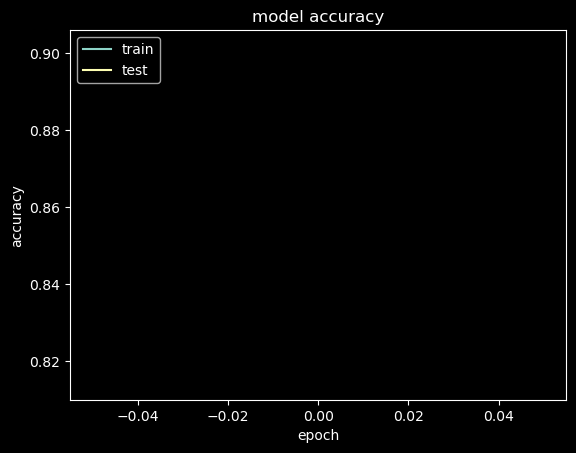

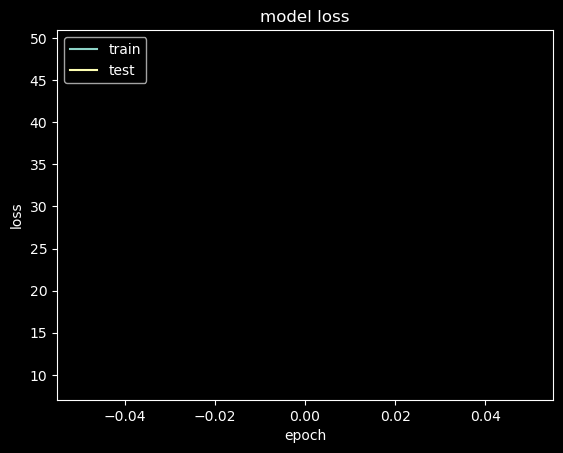

In [14]:
plt.plot(history.history['accuracy']) #variable contains the training accuracy for each epoch.
plt.plot(history.history['val_accuracy']) #  variable contains the validation accuracy for each epoch.
plt.title('model accuracy') #
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss']) #variable contains the training loss for each epoch.
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 9. Model Evaluation

In [15]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 90.156%


## 9. confusion matrix

20/20 [==============================] - 163s 8s/step


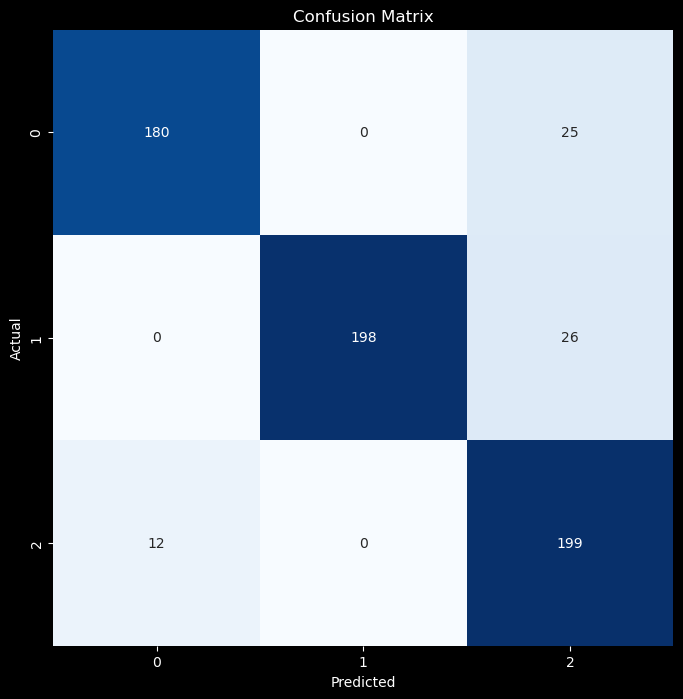

In [16]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [17]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       205
           1       1.00      0.88      0.94       224
           2       0.80      0.94      0.86       211

    accuracy                           0.90       640
   macro avg       0.91      0.90      0.90       640
weighted avg       0.91      0.90      0.90       640

